In [123]:
import multiprocessing
import uuid
import os

if not os.path.exists('out'):
    os.makedirs('out')
if not os.path.exists('results'):
    os.makedirs('results')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.cm import ScalarMappable
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from scipy.stats import pearsonr
mpl.rcParams["text.usetex"] = True

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction


In [2]:
target_name = 'SEIZ_updated'
threads_per_run = multiprocessing.cpu_count()
init_exposures = 100
epsilon = 2
batch_size = 10

parameter_space = ParameterSpace([ContinuousParameter('p', 0, 1),
                                  ContinuousParameter('l', 0, 1),
                                  DiscreteParameter('prop_init_skeptics', np.arange(1, init_exposures, 1, dtype=np.int_))])

In [3]:
def run_job(p, l, init_skeptics, init_adopters):
    with open(f'{target_name}_editable.fred', 'r') as file:
        filedata = file.read()

    vars = {
        'p': p, 
        'l': l, 
        'epsilon': epsilon, 
        'init_skeptic': int(init_skeptics), 
        'init_adopt': int(init_adopters)
    }

    run_uuid = uuid.uuid4()
    var_str = ', '.join(map(lambda item: f'{item[0]}={item[1]}', vars.items()))
    print(run_uuid, var_str)

    with open(f'out/{target_name}_{run_uuid}_out.fred', 'w') as file:
        file.write(filedata.format(**vars))
        
    !fred_job -p out/{target_name}_{run_uuid}_out.fred -k {target_name}_{run_uuid}_run -t {threads_per_run}
    !fred_csv -k {target_name}_{run_uuid}_run > results/{target_name}_{run_uuid}_run.csv

    with open(f'results/{target_name}_{run_uuid}_run.csv', 'r') as file:
        lines = file.readlines()

    with open(f'results/{target_name}_{run_uuid}_run.csv', 'w') as file:
        lines[0] = var_str+'\n'
        file.writelines(lines)

    return pd.read_csv(f'results/{target_name}_{run_uuid}_run.csv', header=2)

In [4]:
def sample(X, clear_results=False):
    X = np.array(X)
    
    if X.ndim < 2:
        X = np.expand_dims(X, 0)
    elif X.ndim > 2:
        raise Exception(f'X has too many dimensions (ndim={X.ndim}, must be 1 or 2)')
    if X.shape[-1] != parameter_space.dimensionality:
        raise Exception(f'X has the wrong number of variables (variables={X.shape[-1]}, must be {parameter_space.dimensionality})')

    X = np.append(X, np.expand_dims(init_exposures-X[:,-1], axis=1), axis=1)  # create and add init_adopters variable

    if clear_results:
        !yes | fred_clear_all_results
    
    Y = []

    with multiprocessing.Pool() as pool:
        for data in pool.starmap(run_job, X):
            S_count = data['ADOPT.totS'].iat[0]
            Y.append([(-data['ADOPT.S'].diff()).max() / S_count])
        
    return np.vstack(Y)

In [5]:
init_design = LatinDesign(parameter_space)
num_data_points = batch_size
X = init_design.get_samples(num_data_points)

In [6]:
X

array([[9.5e-01, 9.5e-01, 6.5e+01],
       [5.0e-02, 5.5e-01, 2.5e+01],
       [6.5e-01, 6.5e-01, 9.4e+01],
       [1.5e-01, 2.5e-01, 5.5e+01],
       [3.5e-01, 8.5e-01, 4.5e+01],
       [5.5e-01, 7.5e-01, 7.4e+01],
       [7.5e-01, 1.5e-01, 8.4e+01],
       [8.5e-01, 3.5e-01, 6.0e+00],
       [2.5e-01, 4.5e-01, 1.6e+01],
       [4.5e-01, 5.0e-02, 3.5e+01]])

In [7]:
Y = sample(X, clear_results=True)

You are about to delete /home/nyoma/FRED/RESULTS. This cannot be undone.
Proceed? yes/no [no]
/home/nyoma/FRED/RESULTS deleted
yes: standard output: Broken pipe
c2f04b07-cc0f-4df1-b9c7-291e08e1810267058939-4a84-481f-bd05-3878e27d93f910944f9e-a1f3-4683-b056-be4f409b98e4b5265139-d1f8-477e-8524-fea50a147737e2db70e5-b6ad-4c96-81bb-b824db5187d7eed35446-b538-4098-8b6e-5899f8880801363fef5f-fd02-4897-a4a7-ab912bb9bc4a116fc0b3-4c3f-428f-b616-b89dd4e249bbe65859f0-4fcd-4ad0-80da-716741ac3c50fc38006c-d33c-4e1e-ad52-bc0a98b5e94f        p=0.95, l=0.95, epsilon=2, init_skeptic=65, init_adopt=35  p=0.6500000000000001, l=0.6500000000000001, epsilon=2, init_skeptic=94, init_adopt=6p=0.05, l=0.55, epsilon=2, init_skeptic=25, init_adopt=75p=0.15000000000000002, l=0.25, epsilon=2, init_skeptic=55, init_adopt=45p=0.35000000000000003, l=0.8500000000000001, epsilon=2, init_skeptic=45, init_adopt=55p=0.8500000000000001, l=0.35000000000000003, epsilon=2, init_skeptic=6, init_adopt=94p=0.55, l=0.75, epsilon=2, i

In [8]:
Y

array([[0.02727393],
       [0.05668829],
       [0.05529812],
       [0.05843153],
       [0.03058387],
       [0.04230107],
       [0.07412066],
       [0.0718037 ],
       [0.05613663],
       [0.0677435 ]])

In [9]:
model_gpy = GPRegression(X,Y)
model_emukit = GPyModelWrapper(model_gpy)

In [10]:
model_variance = ModelVariance(model=model_emukit)
expdesign_loop = ExperimentalDesignLoop(model=model_emukit,
                                        space=parameter_space,
                                        acquisition=model_variance,
                                        batch_size=batch_size)

max_iterations = 25
expdesign_loop.run_loop(sample, max_iterations)

63972746-1ed5-4e7c-988f-512a5dcc25bc1dfa302a-02f0-4b75-bb05-afc2f5e250661201c114-bb29-4756-9835-9283c5cfc9579f9ee4d7-6f59-4423-b30f-9de9e8b86a37455b7b05-26d1-4a18-8570-9a0006be3731ae7fa944-df22-4714-88fc-6add14096106736ca100-2fc5-4c73-945e-b22ee963610acc7d48f4-983d-45a2-bd4d-ad8c406319a14476eae8-be59-4ac9-8c37-3f0a90eef519b653aff4-0867-40d9-8c35-104d526cc07b          p=0.12440615980346414, l=0.8477421431162317, epsilon=2, init_skeptic=1, init_adopt=99p=0.014440470284677098, l=0.9514561429506089, epsilon=2, init_skeptic=89, init_adopt=11p=0.8719524658194711, l=0.10300719245164536, epsilon=2, init_skeptic=50, init_adopt=50p=0.11459194518434557, l=0.970732536658319, epsilon=2, init_skeptic=79, init_adopt=21p=0.15882195387199916, l=0.06228247668708409, epsilon=2, init_skeptic=99, init_adopt=1p=0.9822947612059468, l=0.14112322054227255, epsilon=2, init_skeptic=60, init_adopt=40p=0.9459677848243505, l=0.8411117692909811, epsilon=2, init_skeptic=40, init_adopt=60p=0.9444329466331988, l=0.9599

In [11]:
domain = []

for parameter in parameter_space.parameters:
    if isinstance(parameter, ContinuousParameter):
        domain.append(np.linspace(*parameter.bounds[0], 100))
    elif isinstance(parameter, DiscreteParameter):
        domain.append(parameter.domain)
    else:
        raise NotImplementedError(f'Domain computation not implemented for parameter type {type(parameter)}')

xx_p, yy_l, zz_init_skeptics = np.meshgrid(*domain)

In [12]:
predictions = model_emukit.predict(np.stack((xx_p, yy_l, zz_init_skeptics), axis=-1).reshape(-1, parameter_space.dimensionality))[0].reshape(xx_p.shape)

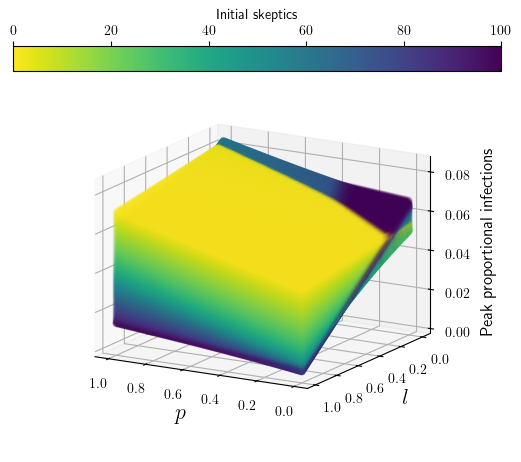

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

color_dim = zz_init_skeptics

ax.scatter(xx_p, yy_l, predictions, c=color_dim, cmap='viridis_r', alpha=0.1)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Peak proportional infections', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_zticks(np.arange(0,0.1,0.02))

norm = plt.Normalize(0, 100)
sm = ScalarMappable(norm=norm, cmap='viridis_r')
cbar = fig.colorbar(sm, ax=ax, label='Initial skeptics', orientation='horizontal', shrink=0.8, location='top', pad=0)

ax.view_init(15, 120, 0)

plt.tight_layout()

plt.show()

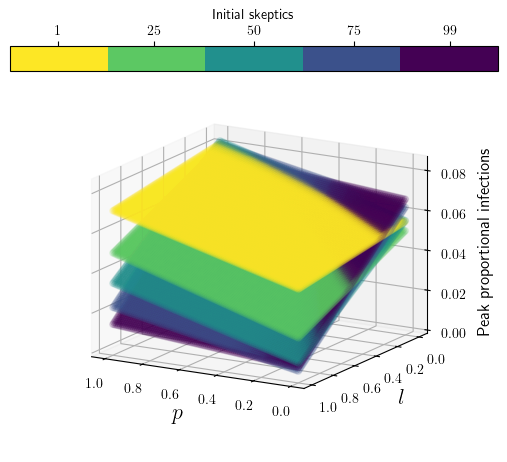

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

init_slice = [0,24,49,74,-1] # this gets values with init_skeptics = 1, 25, 50, 75, or 99
cmap = mpl.cm.get_cmap('viridis_r', len(init_slice))

color_dim = zz_init_skeptics[:,:,init_slice]

ax.scatter(xx_p[:,:,init_slice], yy_l[:,:,init_slice], predictions[:,:,init_slice], c=color_dim, cmap=cmap, alpha=0.15)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Peak proportional infections', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_zticks(np.arange(0,0.1,0.02))

norm = plt.Normalize(-11, 111)
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, ticks=np.unique(color_dim), label='Initial skeptics', orientation='horizontal', shrink=0.8, location='top', pad=0)

ax.view_init(15, 120, 0)

plt.tight_layout()

plt.show()

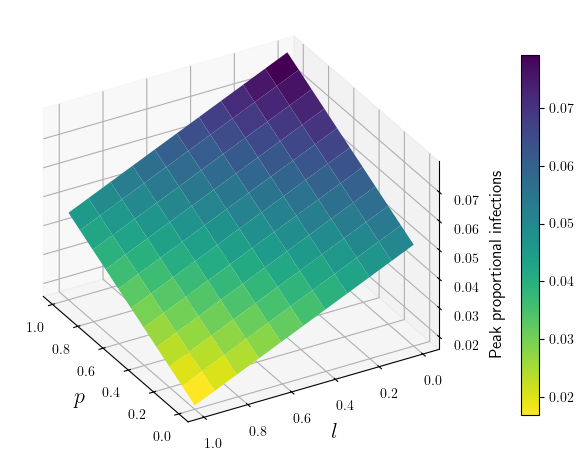

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

init_slice = 29

cmap = plt.get_cmap('viridis_r')

color_dim = predictions[:,:,init_slice]

ax.plot_surface(
    xx_p[:,:,init_slice], 
    yy_l[:,:,init_slice],
    color_dim,
    cmap=cmap,
    rstride=10, cstride=10
)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Peak proportional infections', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
# ax.set_zticks(np.arange(0,0.1,0.02))

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

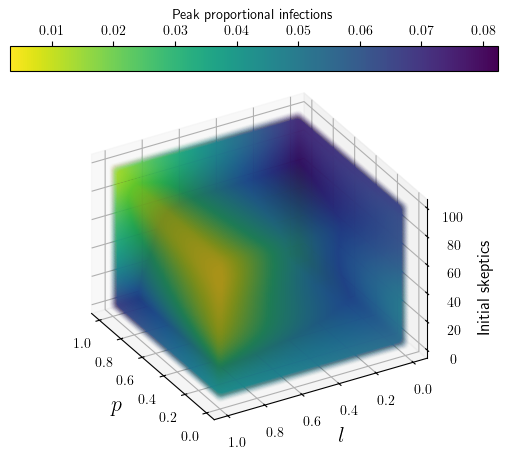

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

color_dim = predictions

ax.scatter(xx_p, yy_l, zz_init_skeptics, c=color_dim, cmap=cmap, alpha=0.01)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Initial skeptics', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_zticks(np.arange(0,101,20))

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0, label='Peak proportional infections', orientation='horizontal', location='top')

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

In [16]:
def group_mean(x,y):
    df = pd.DataFrame(np.stack((x.ravel(),y.ravel()), axis=1)).groupby(0).mean()
    return df.index.to_numpy(), df[1].to_numpy() 

def group_std(x,y):
    df = pd.DataFrame(np.stack((x.ravel(),y.ravel()), axis=1)).groupby(0).std()
    return df.index.to_numpy(), df[1].to_numpy() 

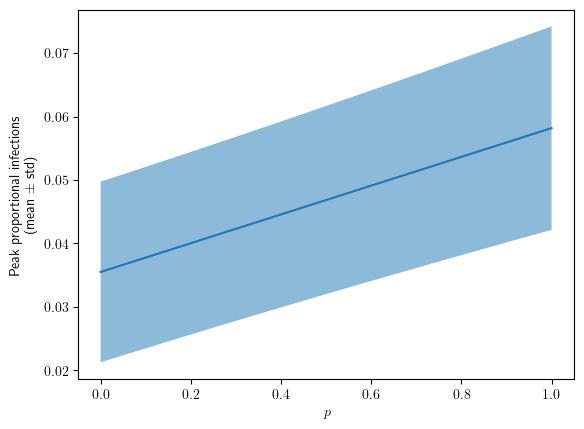

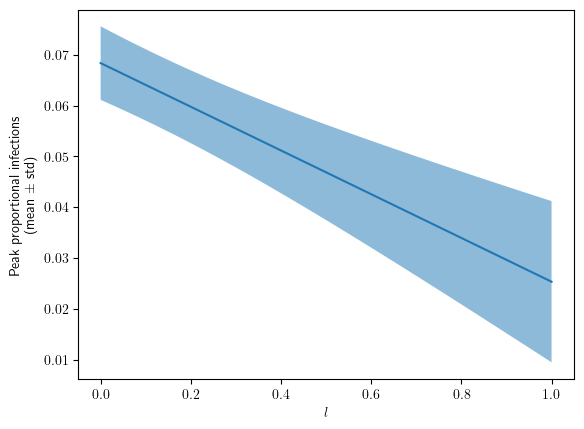

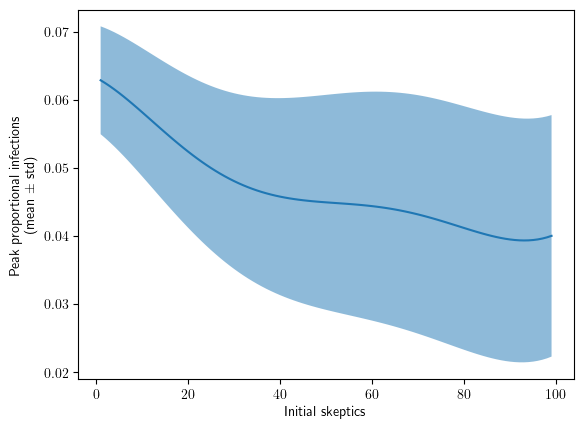

In [17]:
p_mean_idx, p_pred_mean = group_mean(xx_p, predictions)
p_std_idx, p_pred_std = group_std(xx_p, predictions)
# plt.scatter(xx_p.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(p_mean_idx, p_pred_mean)
plt.fill_between(p_std_idx, p_pred_mean+p_pred_std, p_pred_mean-p_pred_std, alpha=0.5)
plt.xlabel('$p$')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

l_mean_idx, l_pred_mean = group_mean(yy_l, predictions)
l_std_idx, l_pred_std = group_std(yy_l, predictions)
# plt.scatter(yy_l.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(l_mean_idx, l_pred_mean)
plt.fill_between(l_std_idx, l_pred_mean+l_pred_std, l_pred_mean-l_pred_std, alpha=0.5)
plt.xlabel('$l$')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

z_mean_idx, z_pred_mean = group_mean(zz_init_skeptics, predictions)
z_std_idx, z_pred_std = group_std(zz_init_skeptics, predictions)
# plt.scatter(zz_init_skeptics.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(z_mean_idx, z_pred_mean)
plt.fill_between(z_std_idx, z_pred_mean+z_pred_std, z_pred_mean-z_pred_std, alpha=0.5)
plt.xlabel('Initial skeptics')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

In [18]:
df = pd.DataFrame({'p': xx_p.ravel(), 'l': yy_l.ravel(), 'init_skeptics': zz_init_skeptics.ravel(), 'prediction': predictions.ravel()})

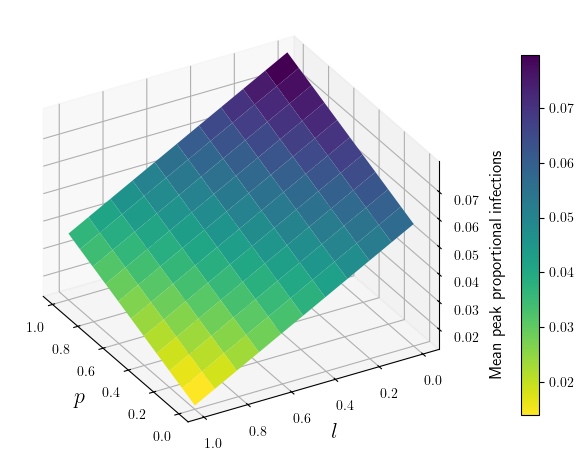

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

grouping = df.groupby(['p','l']).mean()['prediction'].reset_index()

ax.plot_surface(
    np.reshape(grouping['p'], (xx_p.shape[0], yy_l.shape[1])), 
    np.reshape(grouping['l'], (xx_p.shape[0], yy_l.shape[1])),
    np.reshape(grouping['prediction'], (xx_p.shape[0], yy_l.shape[1])),
    cmap=cmap,
    rstride=10, cstride=10
)

color_dim = grouping['prediction']

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Mean peak proportional infections', fontsize=12)

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

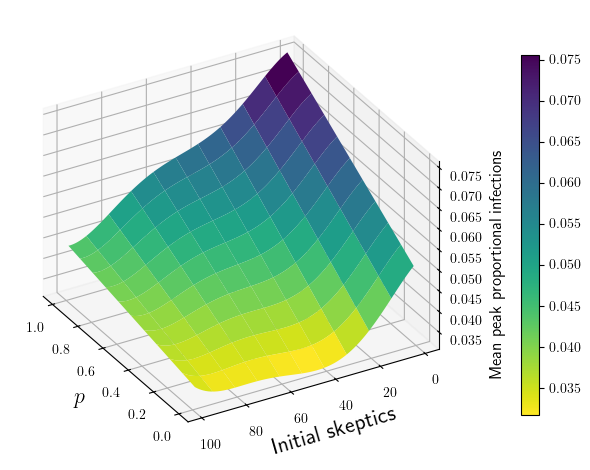

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

grouping = df.groupby(['p','init_skeptics']).mean()['prediction'].reset_index()

ax.plot_surface(
    np.reshape(grouping['p'], (xx_p.shape[0], zz_init_skeptics.shape[2])), 
    np.reshape(grouping['init_skeptics'], (xx_p.shape[0], zz_init_skeptics.shape[2])),
    np.reshape(grouping['prediction'], (xx_p.shape[0], zz_init_skeptics.shape[2])),
    cmap=cmap,
    rstride=10, cstride=10
)

color_dim = grouping['prediction']

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('Initial skeptics', fontsize=16)
ax.set_zlabel('Mean peak proportional infections', fontsize=12)


norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

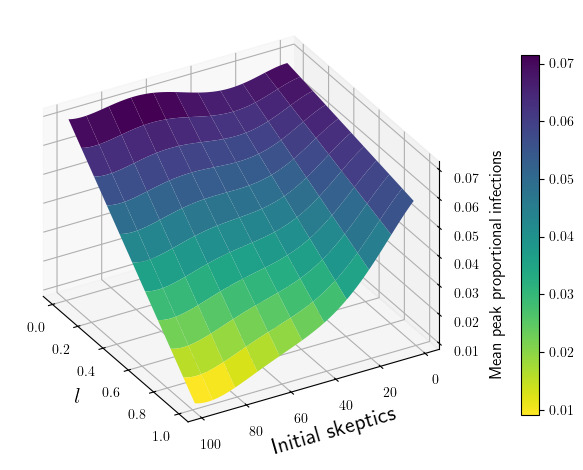

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

grouping = df.groupby(['l','init_skeptics']).mean()['prediction'].reset_index()

ax.plot_surface(
    np.reshape(grouping['l'], (yy_l.shape[1], zz_init_skeptics.shape[2])), 
    np.reshape(grouping['init_skeptics'], (yy_l.shape[1], zz_init_skeptics.shape[2])),
    np.reshape(grouping['prediction'], (yy_l.shape[1], zz_init_skeptics.shape[2])),
    cmap=cmap,
    rstride=10, cstride=10
)

color_dim = grouping['prediction']

ax.set_xlabel('$l$', fontsize=16)
ax.set_ylabel('Initial skeptics', fontsize=16)
ax.set_zlabel('Mean peak proportional infections', fontsize=12)

ax.invert_xaxis()

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

In [97]:
test_design = LatinDesign(parameter_space)
sample_size = 100
X = test_design.get_samples(sample_size)
truth = sample(X)
pred = model_emukit.predict(X)[0]

9027b1b4-4053-41d7-b147-5c30f7a98e776420b136-01fc-4b0a-8797-964f4fa8ff6a2ef947fe-1755-4525-98d7-b50ea27332a943588f98-6ebd-4d8a-8c7e-a37728c2468a02cc232e-ab5a-408f-8542-a81ff473c74986f232b6-3725-44e4-b120-8a63e67cd3ae61e8aad3-975e-4e53-bf06-fa7e7d9adedcb996442c-7cda-4e77-9a47-b7791a6c7f82c849e28b-4daa-40a2-8d23-2f8bc99fd8dfa566afa7-6b96-4f6a-b451-7d4da6aa2842ba0542e6-c7ae-4b57-8ba7-db8cc69934473c164ad7-16bf-4f58-b2b9-db0077359c7922c9c923-5fa1-4044-a083-e47c8dddc12a91e13706-3be0-4f44-b60c-8dc0c3e2cbb4ddc1f957-5cfb-4189-ada3-e65d14265ebe   dbc8323b-8b67-44be-a437-f0860dff7560            p=0.675, l=0.175, epsilon=2, init_skeptic=52, init_adopt=48p=0.41500000000000004, l=0.795, epsilon=2, init_skeptic=93, init_adopt=7p=0.555, l=0.385, epsilon=2, init_skeptic=45, init_adopt=55 p=0.725, l=0.535, epsilon=2, init_skeptic=43, init_adopt=57p=0.845, l=0.7050000000000001, epsilon=2, init_skeptic=90, init_adopt=10p=0.405, l=0.775, epsilon=2, init_skeptic=98, init_adopt=2p=0.065, l=0.045, epsilon=2, 

In [126]:
print('MSE:', mean_squared_error(truth, pred))
print('R2:', r2_score(truth, pred))

MSE: 0.00015950223774531362
R2: 0.4742292250858253


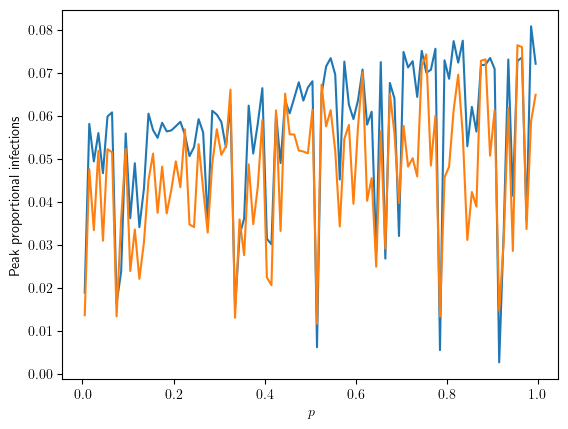

In [99]:
plt.plot(*zip(*sorted(zip(X[:,0], truth))), label='truth')
plt.plot(*zip(*sorted(zip(X[:,0], pred))), label='prediction')

plt.xlabel('$p$')
plt.ylabel('Peak proportional infections')

plt.legend()

plt.show()

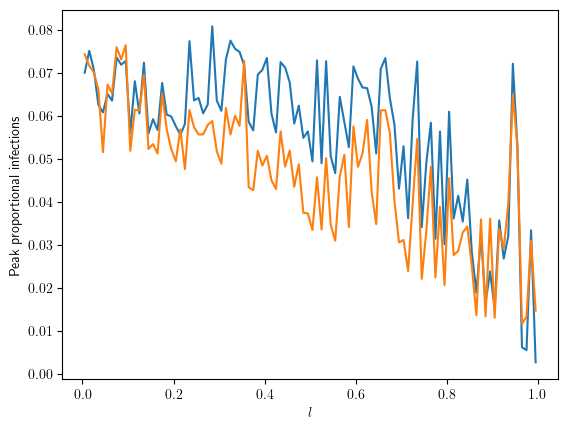

In [100]:
plt.plot(*zip(*sorted(zip(X[:,1], truth))), label='truth')
plt.plot(*zip(*sorted(zip(X[:,1], pred))), label='prediction')

plt.xlabel('$l$')
plt.ylabel('Peak proportional infections')

plt.legend()

plt.show()

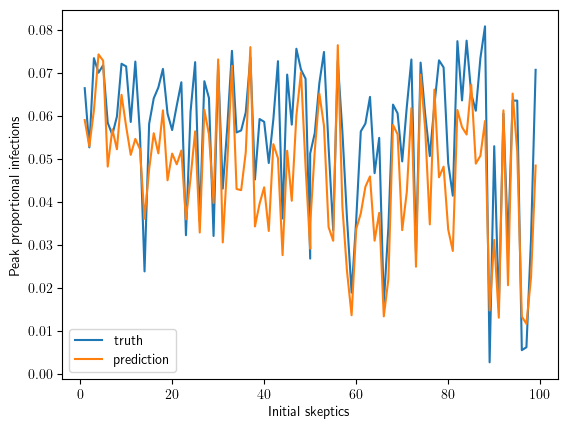

In [101]:
plt.plot(*zip(*sorted(zip(X[:,2], truth))), label='truth')
plt.plot(*zip(*sorted(zip(X[:,2], pred))), label='prediction')

plt.xlabel('Initial skeptics')
plt.ylabel('Peak proportional infections')

plt.legend()

plt.show()

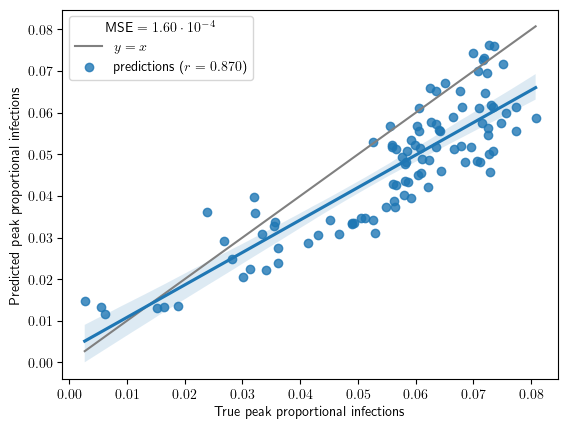

In [170]:
plt.plot([truth.min(),truth.max()],[truth.min(),truth.max()], c='grey', label='$y=x$')

sns.regplot(x=truth, y=pred, label=f'predictions ($r={pearsonr(truth.ravel(),pred.ravel()).statistic:.3f}$)')

plt.xlabel('True peak proportional infections')
plt.ylabel('Predicted peak proportional infections')

coef, exp = ('%.2E' % mean_squared_error(truth, pred)).split('E')
exp = int(exp)
plt.legend(title=f'MSE~$={coef}\cdot10^{{{exp}}}$')

plt.show()